# 1. Preprocessing hand filtering methods

In [10]:
import cv2
import numpy as np


def filter_skin(frame):
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray, 1.1, 2)

    # frame = detect_face(frame)

    # If a face is detected
    if len(faces) > 0:
        # Get the coordinates of the face
        (x, y, w, h) = faces[0]

        # Set the region of the image that contains the face to black
        frame[
            y - 30 : y + h + 50,
            x - 10 : x + w + 10,
        ] = 0

        frame[
            y - 30 : y + h + 85,
            x + 10 : x + w - 30,
        ] = 0
    # else:
    # print("no faces")
    # Apply edge detection
    edges = cv2.Canny(gray, 30, 100)

    # Find contours in the edge image
    contours, _ = cv2.findContours(
        edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter contours based on their area
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]

    # Set the regions of the image that contain the large contours to black
    for cnt in large_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        frame[y - 15 : y + h + 10, x - 20 : x + w + 60] = 0

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define a range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the HSV image to get only skin colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on their area
    hand_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]

    # # Draw the hand contours on the frame
    # cv2.drawContours(frame, hand_contours, -1, (0, 255, 0), 3)

    # Create a blank black image
    hand_mask = np.zeros(frame.shape[:2], dtype="uint8")

    # # Fill in the hand contours with white
    # cv2.drawContours(hand_mask, hand_contours, -1, 255, thickness=cv2.FILLED)

    # Fill in the hand contours with white
    cv2.drawContours(hand_mask, hand_contours, -1, 255, thickness=cv2.FILLED)

    # Create a mask where everything outside of the hand contours is black
    # outside_mask = cv2.bitwise_not(hand_mask)

    # Set everything outside of the hand contours to black in the original image
    frame = cv2.bitwise_and(frame, frame, mask=hand_mask)

    return frame


def filter_edges(frame):
    # Apply Canny filter
    # frame = cv2.Canny(frame, 100, 200)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])

    # lower_skin = np.array([0, 48, 80], dtype=np.uint8)
    # upper_skin = np.array([150, 255, 255], dtype=np.uint8)

    # mask = cv2.inRange(hsv, lower_skin, upper_skin)

    kernel = np.ones((3, 3), np.uint8)

    # # Apply opening to the mask
    # mask_smoothed = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    edges = cv2.Canny(gray, 50, 150)

    # Dilate the edges to make them thicker
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # lines = cv2.HoughLinesP(
    #     edges, 1, np.pi / 180, 75, minLineLength=0.01, maxLineGap=5
    # )

    # for line in lines:
    #     x1, y1, x2, y2 = line[0]
    #     cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return dilated_edges


def resize_image(frame):
    return cv2.resize(frame, (256, 256))


def apply_image_filters(frame):
    filter_1 = filter_skin(frame)
    filter_2 = filter_edges(filter_1)
    return filter_2

# 2. Capture a single image

In [155]:
import cv2

capture = cv2.VideoCapture(0)
# Check if the camera is opened successfully
if not capture.isOpened():
    print("Unable to open the camera")

# Read a frame from the camera
ret, frame = capture.read()

# Check if the frame is read successfully
if not ret:
    print("Failed to read frame from the camera")

cv2.imwrite("./examples/N.jpg", frame)
print("Image saved successfully")

Image saved successfully


# 3. Example images for verification

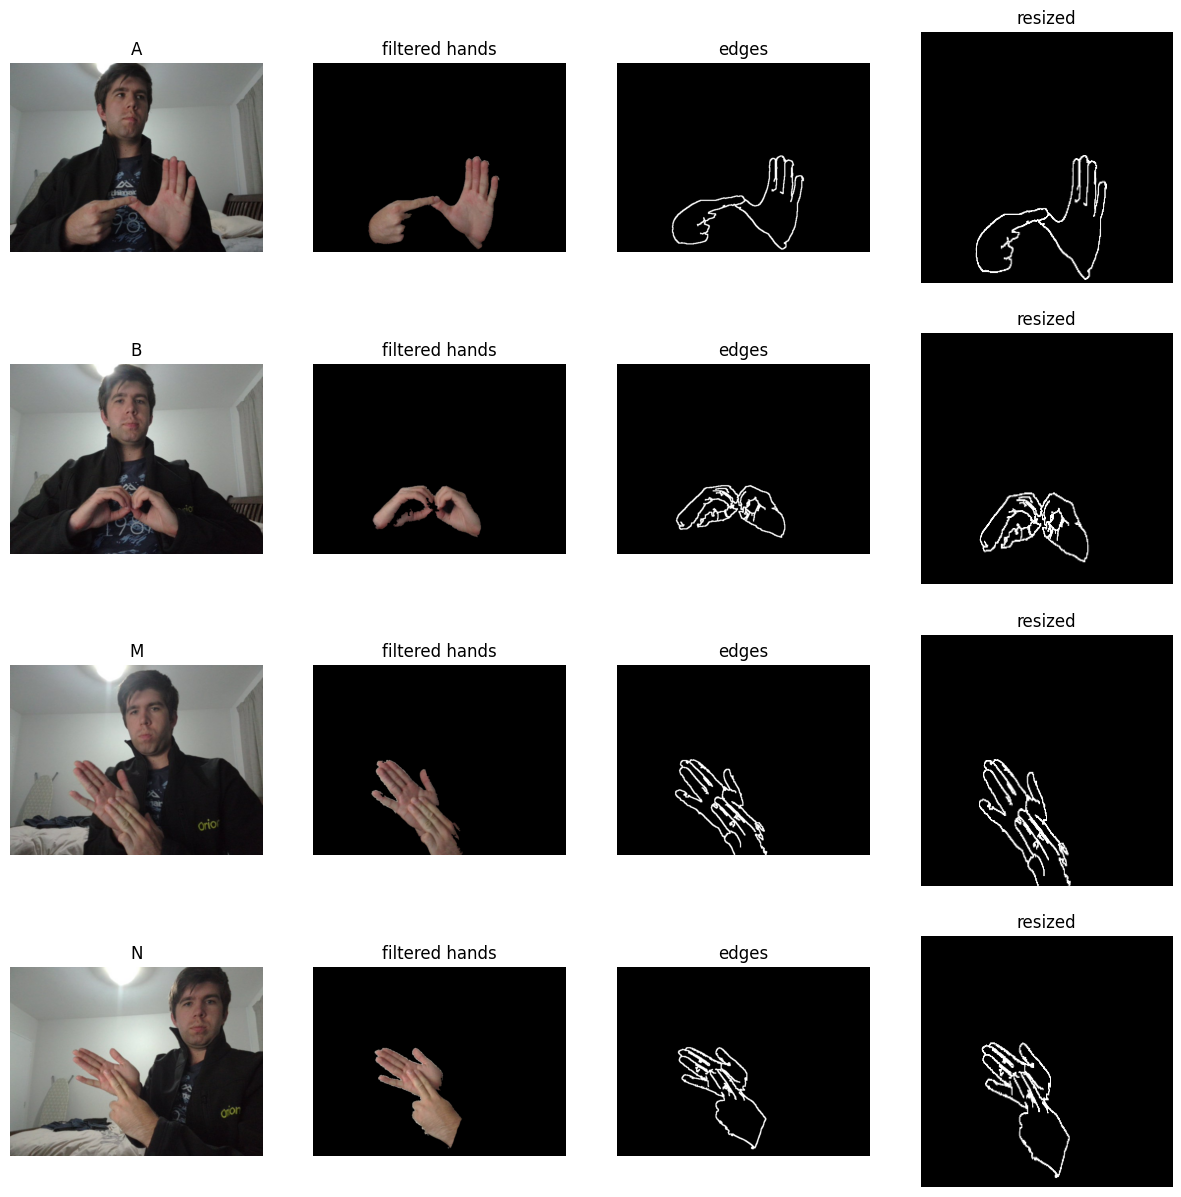

In [3]:
import matplotlib.pyplot as plt
import cv2

frame_A = cv2.imread("./examples/A.jpg")
frame_B = cv2.imread("./examples/B.jpg")
frame_C = cv2.imread("./examples/M.jpg")
frame_X = cv2.imread("./examples/N.jpg")


class ImagePlotter:
    def __init__(self, rows, cols):
        self.counter = 0
        self.rows = rows
        self.cols = cols
        self.positions = [
            i for j in range(cols) for i in range(j + 1, rows * cols + 1, cols)
        ]

    def plot_image(self, name, frame):
        plt.subplot(self.rows, self.cols, self.positions[self.counter])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(name)
        self.counter += 1
        

plotter = ImagePlotter(4, 4)

plt.figure(figsize=(15, 15))

plotter.plot_image("A", frame_A)
plotter.plot_image("B", frame_B)
plotter.plot_image("M", frame_C)
plotter.plot_image("N", frame_X)

frame_A = filter_skin(frame_A)
frame_B = filter_skin(frame_B)
frame_C = filter_skin(frame_C)
frame_X = filter_skin(frame_X)

plotter.plot_image("filtered hands", frame_A)
plotter.plot_image("filtered hands", frame_B)
plotter.plot_image("filtered hands", frame_C)
plotter.plot_image("filtered hands", frame_X)

frame_A = filter_edges(frame_A)
frame_B = filter_edges(frame_B)
frame_C = filter_edges(frame_C)
frame_X = filter_edges(frame_X)

plotter.plot_image("edges", frame_A)
plotter.plot_image("edges", frame_B)
plotter.plot_image("edges", frame_C)
plotter.plot_image("edges", frame_X)

frame_A = resize_image(frame_A)
frame_B = resize_image(frame_B)
frame_C = resize_image(frame_C)
frame_X = resize_image(frame_X)

plotter.plot_image("resized", frame_A)
plotter.plot_image("resized", frame_B)
plotter.plot_image("resized", frame_C)
plotter.plot_image("resized", frame_X)

plt.xlabel("")

plt.axis("off")
plt.show()

# 4. Live run of filtered image for testing

In [134]:
import cv2

# Open the video source or camera
capture = cv2.VideoCapture(0)

# Check if the video source or camera is opened successfully
if not capture.isOpened():
    print("Unable to open the video source or camera")

# Loop through the frames
while True:
    # Read a frame from the video source or camera
    ret, frame = capture.read()

    filtered_frame = apply_image_filters(frame)

    # Check if the frame is read successfully
    if not ret:
        print("Failed to read frame from the video source or camera")
        break

    # Perform operations on the frame
    # For example, you can display the frame
    cv2.imshow("Frame", filtered_frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the video source or camera and close all windows
capture.release()
cv2.destroyAllWindows()

# 5. Collect training data

In [13]:
collection_classes = [
    "no hands" "my",
    "name",
    "hello",
    "A",
    "B",
    "C",
    "M",
    "N",
    "X"
    # "D": 2,
    # "A": 2,
    # "N": 2,
    # "I": 2,
    # "E": 2,
    # "L": 2,
]


DATA_PATH = "./testing_data/"

CSV_FILE = "./testing_data/training_data.csv"

capture_frames = 20
n_sequences = 100
capture_interval = 1.5

In [54]:
import cv2
import time
import os
import pandas as pd

# (0) in VideoCapture is used to connect to your computer's default camera
capture = cv2.VideoCapture(0)

# Initializing current time and previous time for calculating the FPS
previousTime = 0
currentTime = 0


previous_capture_time = time.time()
capturing = False


current_class = 0
sequences_captured = 0
capture_frame = 0

paused = -1

csv_file = open(CSV_FILE, "w")

while capture.isOpened():
    # capture frame by frame
    ret, frame = capture.read()

    # resizing the frame for better view
    image = cv2.resize(frame, (800, 600))

    # Converting the from BGR to RGB
    image = apply_image_filters(image)

    if capturing:
        # Making predictions using holistic model
        # To improve performance, image is marked as not writeable to pass by reference.

        folder_path = (
            f"{DATA_PATH}/{collection_classes[current_class]}/{sequences_captured}"
        )

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        resized_frame = cv2.resize(image, (256, 256))

        flattened_image = resized_frame.flatten()

        if capture_frame > 0:
            cv2.imwrite(folder_path + f"/{capture_frame}.jpg", resized_frame)

            csv_file.write(
                f"{current_class},{','.join([str(pixel) for pixel in flattened_image])}\n"
            )

        capture_frame += 1

        if capture_frame == capture_frames:
            capturing = False
            previous_capture_time = time.time()
            capture_frame = 0
            sequences_captured += 1

            if sequences_captured == n_sequences:
                sequences_captured = 0
                current_class += 1
                if current_class == len(collection_classes):
                    print("Data collection complete")
                    break

    if not capturing:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if paused == 1:
            cv2.putText(
                image,
                "paused, press p to continue",
                (215, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
        else:
            cv2.putText(
                image,
                "Get ready to capture",
                (225, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
            if time.time() - previous_capture_time >= capture_interval:
                capturing = True

    # Calculating the FPS
    currentTime = time.time()
    fps = 1 / (currentTime - previousTime)
    previousTime = currentTime

    # Displaying FPS on the image
    cv2.putText(
        image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    cv2.putText(
        image,
        "capturing "
        + str(sequences_captured + 1)
        + " of "
        + str(n_sequences)
        + ' for "'
        + str(collection_classes[current_class])
        + '"',
        (10, 575),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    cv2.putText(
        image,
        "class " + str(current_class + 1) + " of " + str(len(collection_classes)),
        (525, 575),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Display the resulting image
    cv2.imshow("Facial and Hand Landmarks", image)

    # Enter key 'q' to break the loop
    key = cv2.waitKey(5) & 0xFF

    quit_key = ord("q")
    paused_key = ord("p")

    if key == quit_key:
        break
    elif key == paused_key:
        paused *= -1
        previous_capture_time = time.time()


csv_file.close()

capture.release()
cv2.destroyAllWindows()

Data collection complete


# 6. Load the data into dataloaders

In [55]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


class HandDataset(Dataset):
    def __init__(self, data):
        self.labels = data[:, :, 0][:, 0]  # Extract the label column
        self.data = data[:, :, 1:]  # Exclude the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            "data": torch.tensor(self.data[idx], dtype=torch.float32),
            "label": torch.tensor(
                self.labels[idx], dtype=torch.float32
            ),  # .reshape(1),
        }
        return sample


# Load the processed data from the CSV file
processed_data = np.loadtxt(CSV_FILE, delimiter=",")

image_size = 256 * 256

reshaped_data = processed_data.reshape(-1, capture_frames, image_size + 1)

# Create a dataset from the processed data
dataset = HandDataset(reshaped_data)

# # Split the dataset into training and testing sets
# train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# # Create data loaders for training and testing sets
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the indices of the data and split them
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.75, random_state=42)

# Create subsets based on the split indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

training_batch_size = 100
test_batch_size = 25

# Create data loaders for training and testing sets
train_dataloader = DataLoader(
    train_dataset, batch_size=training_batch_size, shuffle=True
)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# Loop through each batch in the training set
for batch in train_dataloader:
    data = batch["data"]
    label = batch["label"]
    print(label)
    print(data.shape)
    print(label.shape)

tensor([0., 0., 1., 2., 2., 3., 1., 1., 3., 3., 0., 3., 1., 3., 0., 1., 3., 1.,
        3., 2., 1., 2., 0., 1., 1., 0., 2., 2., 1., 3., 3., 1., 2., 3., 2., 3.,
        0., 1., 1., 1., 1., 0., 3., 2., 2., 3., 2.])
torch.Size([47, 20, 65536])
torch.Size([47])


# 7. Define the LSTM and dataset models and parameters

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_classes = [
    "hello",
    "A",
    "B",
    "C",
    # "no hands" "my",
    # "name",
    # "hello",
    # "A",
    # "B",
    # "C",
    # "M",
    # "N",
    # "X"
    # "D": 2,
    # "A": 2,
    # "N": 2,
    # "I": 2,
    # "E": 2,
    # "L": 2,
]

input_size = 256 * 256
hidden_size = 128
num_layers = 2
num_classes = len(training_classes)


# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         # Set initial hidden and cell states
#         # print(x.shape)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))

#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out


# # LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # Only take the output from the last time step
#         return out


class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.2
    ):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_prob,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for BiLSTM

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out


class FeatureDataset(Dataset):
    def __init__(self, keypoints, labels):
        self.keypoints = keypoints
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.keypoints[idx]), torch.LongTensor(
            [self.labels[idx]]
        )

# 8. Train the LSTM model

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load your CSV file without a header
df = pd.read_csv(CSV_FILE, header=None)

# Extract labels and keypoint data columns
labels = df.iloc[:, 0].astype("category").cat.codes.values
keypoints = df.iloc[:, 1:]

# Normalize keypoints if needed (you might want to customize this based on your data)
scaler = StandardScaler()
keypoints_normalized = scaler.fit_transform(keypoints)

# Reshape the data into sequences of 30 frames
keypoints_reshaped = keypoints_normalized.reshape(
    -1, capture_frames, len(keypoints.columns)
)

# Ensure the number of samples in keypoints_reshaped matches the number of labels
num_samples = min(len(labels), len(keypoints_reshaped))
keypoints_reshaped = keypoints_reshaped[:num_samples]
labels = labels[::capture_frames]

# Split the data into training and validation sets
keypoints_train, keypoints_val, labels_train, labels_val = train_test_split(
    keypoints_reshaped, labels, test_size=0.15, random_state=42
)


# Create instances of the dataset for training and validation
train_dataset = FeatureDataset(keypoints_train, labels_train)
val_dataset = FeatureDataset(keypoints_val, labels_val)

# Create DataLoader instances
training_batch_size = 85
validation_batch_size = 15
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=False)

# Set model parameters
# input_size = len(keypoints.columns)  # Number of keypoints in each frame
# hidden_size = 128
# num_layers = 2
# num_classes = len(df.iloc[:, 0].unique())  # Number of unique classes

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, labels in val_loader:
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            # print(labels.squeeze(1))
            # print(preds)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(all_labels, all_preds)
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}"
    )

torch.save(model.state_dict(), "../models/lstm_image_rnn.pth")

Epoch [1/10], Loss: 1.3790, Validation Accuracy: 0.3103
Epoch [2/10], Loss: 1.2682, Validation Accuracy: 0.4828
Epoch [3/10], Loss: 1.1955, Validation Accuracy: 0.4828
Epoch [4/10], Loss: 1.1280, Validation Accuracy: 0.6207
Epoch [5/10], Loss: 1.0662, Validation Accuracy: 0.6552
Epoch [6/10], Loss: 1.0135, Validation Accuracy: 0.6897
Epoch [7/10], Loss: 0.9479, Validation Accuracy: 0.7586
Epoch [8/10], Loss: 0.8994, Validation Accuracy: 0.7931
Epoch [9/10], Loss: 0.8325, Validation Accuracy: 0.8276
Epoch [10/10], Loss: 0.7787, Validation Accuracy: 0.9310


# 9. Visualise labels and predictions from training dataset

In [80]:
print(training_classes)

for data, labels in val_loader:
    outputs = model(data)
    preds = torch.argmax(outputs, dim=1)

    print(labels)
    print(preds)

['hello', 'A', 'B', 'C']
tensor([[3],
        [3],
        [2],
        [1],
        [2],
        [0],
        [0],
        [0],
        [2],
        [2],
        [2],
        [2],
        [0],
        [3],
        [1]])
tensor([3, 3, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 3, 1])
tensor([[2],
        [2],
        [1],
        [1],
        [0],
        [0],
        [0],
        [3],
        [2],
        [1],
        [2],
        [2],
        [0],
        [0]])
tensor([2, 3, 2, 1, 0, 0, 0, 3, 2, 1, 2, 2, 0, 0])


# 10. Load the model and test live

In [14]:
import cv2
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import torch.nn as nn


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# load the model
# Set model parameters
# input_size = 256 * 256
# hidden_size = 128
# num_layers = 2
# num_classes = len(training_classes)
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load("./models/lstm_image_rnn.pth"))
model.eval()

SCALER = StandardScaler()
ENCODER = LabelEncoder()

device = torch.device("cpu")  # "cuda" if torch.cuda.is_available() else "cpu")

frame_buffer = []
output_buffer = []


# Function to process the frame and make predictions
def process_frame(image):
    global frame_buffer, output_buffer

    resized_frame = cv2.resize(image, (256, 256))

    flattened_image = resized_frame.flatten()

    frame_buffer.append(flattened_image)

    # Maintain only the last 5 frames in the buffer
    if len(frame_buffer) >= capture_frames:
        frame_buffer = frame_buffer[-capture_frames:]

    if len(frame_buffer) == capture_frames:
        # df = pd.DataFrame(frame_buffer)

        # input_tensor = torch.tensor(df, dtype=torch.float32)
        # input_tensor = input_tensor.unsqueeze(0).to(device)
        values = np.array(frame_buffer)
        input_tensor = torch.tensor(values, dtype=torch.float32)
        input_tensor = input_tensor.view(1, capture_frames, -1).to(
            device
        )  # Reshape the input tensor

        with torch.no_grad():
            output = model(input_tensor)
            output_buffer.append(output)

            _, predicted_class = torch.max(output, 1)

            return training_classes[predicted_class]


displayed_prediction = None
previousTime = 0
previousTime_1 = 0

# Open the video capture
capture = cv2.VideoCapture(0)

# Loop through the frames
while capture.isOpened():
    # Read the frame from the video capture
    ret, image = capture.read()

    # resizing the frame for better view
    image = cv2.resize(image, (800, 600))

    filtered_image = apply_image_filters(image)

    # Process the frame and make predictions
    prediction = process_frame(filtered_image)

    visual_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2RGB)

    if prediction is not None:
        # Draw the predictions on the frame (if required)
        cv2.putText(
            visual_image,
            f"Prediction: {prediction}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )

    # Calculating the FPS
    fps = 1 / (time.time() - previousTime)
    previousTime = time.time()

    # Displaying FPS on the image
    cv2.putText(
        visual_image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Display the image
    cv2.imshow("Frame", visual_image)

    # Check for key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break


# Release the video capture and close the window
capture.release()
cv2.destroyAllWindows()